In [1]:
import os

dataset_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/QM9_smi_datasets/train_test_dataset_100000.smi"
validation_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/QM9_smi_datasets/validation.smi"
json_cache_location = os.environ["DATA"] + "/00_datasets/DFT/QM9/cache_QM9.json"

output_results_path = os.environ["DATA"] + "/07_BBO/02_models/05.03_GPR_HOMO_QM9/"
DFT_output_results_path = os.environ["DATA"] + "/07_BBO/02_models/05.03_bis_GPR_HOMO_QM9_DFT/"
test_20k_output_results_path = os.environ["DATA"] + "/07_BBO/02_models/05.03_ter_GPR_HOMO_QM9_DFT_20k/"
test_20k_fast_output_results_path = os.environ["DATA"] + "/07_BBO/02_models/05.03_quad_GPR_HOMO_QM9_DFT_fast_20k/"
test_30k_fast_output_results_path = os.environ["DATA"] + "/07_BBO/02_models/05.03_pent_GPR_HOMO_QM9_DFT_fast_30k/"
hyperparameters_optim_output_results_path = os.environ["DATA"] + "/07_BBO/02_models/05.03_sexies_GPR_HOMO_OD9_7_hyperparameters/"

N_MOL_TRAIN_TEST = 5000
N_MOL_VALIDATION = 10000
CV = 10

N_JOBS=10

ALPHAS = [1e-7, 1e-5, 1e-3, 1e-1, 1e0]




In [2]:
from os import makedirs

makedirs(output_results_path, exist_ok=True)

In [3]:
import numpy as np
from sklearn.gaussian_process.kernels import StationaryKernelMixin, NormalizedKernelMixin, Kernel

class SOAPKernelIter(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    
    def __init__(self, xi=2):
        self.xi = xi
    
    def __call__(self, X, Y=None, eval_gradient=False):
        
        if Y is None:
            Y = X
            
        kernel_values = np.zeros((X.shape[0], Y.shape[0]))
        
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                p1 = X[i]
                p2 = Y[j]
                
                kernel_values[i][j] = ((np.dot(p1, p2))/np.sqrt(np.dot(p1, p1)*np.dot(p2, p2)))**self.xi
                
        return kernel_values
        
    def get_params(self, deep=True):
        return {"xi": self.xi}


In [4]:
class SOAPKernelVectorized(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    
    def __init__(self, xi=2):
        self.xi = xi
        
    def __call__(self, X, Y=None, eval_gradient=False):
        
        if Y is None:
            Y = X
            
        # Extracting the dimensions of both matrices
        X_dim = X.shape[0]
        Y_dim = Y.shape[0]

        # Computing the dot product of each matrix with itself and with the other
        dot_X_X = X.dot(X.T)
        dot_X_Y = X.dot(Y.T)
        dot_Y_Y = Y.dot(Y.T)

        # Extracting the dot product of each element of each matrix with itself
        diag_X = np.diag(dot_X_X)
        diag_Y = np.diag(dot_Y_Y)

        # Building the matrix of dimension (X_dim, Y_dim) containing in each line the dot product of the nth
        # element of X with itself
        X_dot_matrix = np.tile(diag_X, Y_dim).reshape((Y_dim, X_dim)).T

        # Building the matrix of dimension (X_dim, Y_dim) containing in each column the dot product of the nth
        # element of Y with itself
        Y_dot_matrix = np.tile(diag_Y, X_dim).reshape((X_dim, Y_dim))

        # Computing the SOAP kernel of X and Y
        return (dot_X_Y/np.sqrt(X_dot_matrix * Y_dot_matrix))**self.xi
    

    def get_params(self, deep=True):
        return {"xi": self.xi}


In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern, RationalQuadratic, DotProduct


kernels = [("RBF( 1.0)", RBF(1.0)),
           ("DotProduct( sigma_0=1)", DotProduct(sigma_0=1)),
           ("SOAP( xi=1)", SOAPKernelVectorized(xi=1)),
           ("SOAP( xi=2)", SOAPKernelVectorized(xi=2)),
           ("SOAP( xi=3)", SOAPKernelVectorized(xi=3))]

models = []
for kernel in kernels:
    models.append((kernel[0], GaussianProcessRegressor(kernel=kernel[1], optimizer=None)))


In [6]:
from bbo.descriptor import SOAPDesc, ShinglesVectDesc, MBTRDesc, CoulombMatrixDesc

descriptors = [
    ("SOAP", SOAPDesc(cache_location=None, n_jobs=12, average="inner", rcut=4, nmax=6, 
                      lmax=8, species=["C", "H", "O", "N", "F"])),
    ("Shingles bool", ShinglesVectDesc(cache_location=None)),
    ("Shingles count", ShinglesVectDesc(cache_location=None, count=True)),
    ("MBTR", MBTRDesc(cache_location=None, n_jobs=12, cosine_angles_n=45, atomic_numbers_n=10, 
                      inverse_distances_n=45, species=["C", "H", "O", "N", "F"])),
    ("CM", CoulombMatrixDesc(n_atoms_max=29, cache_location=None, n_jobs=12)),
    
]

init MBTR


In [7]:
from bbo.objective import EvoMolEvaluationStrategyWrapper
from evomol.evomol.evaluation_dft import OPTEvaluationStrategy

objective = EvoMolEvaluationStrategyWrapper(
    OPTEvaluationStrategy("homo", n_jobs=2, cache_files=[json_cache_location], 
                          working_dir_path="/home/jleguy/dft_comput",
                          MM_program="rdkit"))

133798 molecules in cache


In [8]:
from os.path import join
import numpy as np
from sklearn.preprocessing import normalize, scale


def compute_desc_obj(smiles_list, desc_builder, objective):
    
    X, success = desc_builder.transform(smiles_list)
    X = X[success]
    
    smiles_list_filtered = np.array(smiles_list)[success]
    
    y, all_scores, success = objective.transform(smiles_list_filtered)
    
    smiles_list_filtered = np.array(smiles_list_filtered)[success]
    
    return X[success], y[success], smiles_list_filtered
    

def compute_data_descriptor(desc_builder, objective):
    
    smiles_train = []
    smiles_validation = []
    
    with open(dataset_path, "r") as f:
        for smi in f.readlines()[:N_MOL_TRAIN_TEST]:
            smiles_train.append(smi.rstrip())
            
    X_train, y_train, smiles_train = compute_desc_obj(smiles_train, desc_builder, objective)
    
    
    with open(validation_path, "r") as f:
        for smi in f.readlines()[:N_MOL_VALIDATION]:
            smiles_validation.append(smi.rstrip())
            
    X_validation, y_validation, smiles_validation = compute_desc_obj(smiles_validation, desc_builder, objective)
        
    return X_train, y_train, X_validation, y_validation, smiles_train, smiles_validation


In [9]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import time
from sklearn.pipeline import Pipeline

def evaluate_model(model, X_train, y_train, X_validation, y_validation, smiles_validation, preprocessing=None):
    """
    Evaluating the current model by performing a grid search of the alpha parameter on the train set.
    The best parameters are used to fit a model on the whole training data that is evaluated on the validation 
    data.
    Returning : 
    mean MAE on the CV folds (best parameters),
    MAE of the refitted model on the validation set,
    Vector of true values for the validation set,
    Vector of predicted values for the validation set,
    mean time to train the models on the CV folds (best parameters),
    alpha value of the best model,
    sklearn.model_selection.GridSearchCV.cv_results_ dictionary
    """
    
    if preprocessing is not None:
        preprocessing_and_model = Pipeline([
            ("Preprocessing", preprocessing),
            ("model", model)
        ])
        alpha_key = "model__alpha"
        param_grid = {alpha_key: ALPHAS}
    else:
        preprocessing_and_model = model
        alpha_key = "alpha"
        param_grid = {alpha_key: ALPHAS}
        
    grid_search = GridSearchCV(preprocessing_and_model, param_grid=param_grid, cv=CV,
                               scoring="neg_mean_absolute_error", verbose=10,
                               n_jobs=N_JOBS)
    
    # Performing the grid search
    grid_search.fit(X_train, y_train)
 
    
    # Evaluating on the validation set the model with best parameters retrained on the whole training set
    y_valid_pred = grid_search.predict(X_validation)
    
    # Filtering possible nan values from predictions
    nan_filter = np.isnan(y_valid_pred)
    y_valid_pred = y_valid_pred[np.logical_not(nan_filter)]
    y_validation = y_validation[np.logical_not(nan_filter)]
    smiles_validation = smiles_validation[np.logical_not(nan_filter)]
    
    
    validation_MAE = float(mean_absolute_error(y_validation, y_valid_pred))
        
    # Computing the indice of the best parameter
    idx_best_param = np.argmin(grid_search.cv_results_["rank_test_score"])
        
    # Extracting mean train time of the best model
    mean_train_time_best_model = grid_search.cv_results_["mean_fit_time"][idx_best_param]
    
    # Extracting best alpha value
    best_alpha = grid_search.cv_results_["params"][idx_best_param][alpha_key]
    
    return -grid_search.best_score_, validation_MAE, y_validation, y_valid_pred, smiles_validation, \
        mean_train_time_best_model, best_alpha, grid_search.cv_results_


In [10]:
from os.path import join
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import csv
sns.set(style="ticks", color_codes=True)


def init_results_dict(models, descriptors):
    
    results_dict = {}
    results_dict["kernel"] = [model[0] for model in models]
    for descriptor in descriptors:
        results_dict[descriptor[0]] = []
    
    return results_dict

def save_dictionary_to_csv_file(d, output_results_path, name, separator=","):
    
    makedirs(output_results_path, exist_ok=True)
    pd.DataFrame.from_dict(d).to_csv(join(output_results_path, name + ".csv"), sep=separator, encoding="utf-8")
    
def display_dict(name, d):
    display(HTML('<h3>' + name +'</h3>'))
    display(pd.DataFrame.from_dict(d))
    
def plot_errors_save_prediction_data(desc_name, model_name, y_true, y_pred, smiles_list, output_root, n_smiles=10):
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 7))
    
    # Plotting true vs. predicted values
    axes[0].set_xlabel("True HOMO value (eV)")
    axes[0].set_ylabel("Predicted HOMO value (eV)")
    axes[0].set_xlim((-11, 0.5))
    axes[0].set_ylim((-11, 0.5))
    sns.scatterplot(x=y_true, y=y_pred, ax=axes[0], alpha=0.2)
    sns.lineplot(x=np.linspace(-11, 0.5), y=np.linspace(-11, 0.5), ax=axes[0])
    
    # Plotting absolute error distribution
    axes[1].set_xlabel("Absolute error distribution (eV)")
    axes[1].set_yscale("log")
    axes[1].set_xlim((0, 10))
    sns.distplot(np.abs(y_true-y_pred), ax=axes[1], kde=False, bins=np.linspace(0, 10, 50))
    
    # Computing name of experient
    exp_name = desc_name + "_" + model_name
    
    # Saving the figure
    plt.savefig(join(output_root, exp_name + "_error_plot.png"), dpi=200)
    
    # Extracting the MAE and SMILES for max errors
    sorted_max_abs_errors_mask = np.argsort(np.abs(y_true - y_pred))[-n_smiles:][::-1]
    max_abs_errors_smiles = smiles_list[sorted_max_abs_errors_mask]
    max_abs_errors_errors = (y_true-y_pred)[sorted_max_abs_errors_mask]
    
    # Saving the max errors data in a CSV file
    with open(join(output_root, exp_name + "_max_errors.csv"), "w") as f:
        writer = csv.writer(f)
        for i in range(n_smiles):
            writer.writerow([max_abs_errors_smiles[i], max_abs_errors_errors[i]])
    
    # Saving the prediction data (CSV 3 lines : SMILES, True HOMO, Predicted HOMO)
    with open(join(output_root, exp_name + "_errors.csv"), "w") as f:
        writer = csv.writer(f)
        writer.writerow(list(smiles_list))
        writer.writerow(list(y_true))
        writer.writerow(list(y_pred))
    
def procedure(models, descriptors, objective, output_results_path, preprocessing=None):
    
    CV_score_best_params_dict = init_results_dict(models, descriptors)
    validation_score_best_params_dict = init_results_dict(models, descriptors)
    mean_train_time_dict = init_results_dict(models, descriptors)
    best_alpha_dict = init_results_dict(models, descriptors)
    cv_results_dict = init_results_dict(models, descriptors)
    
    
    # Computing the name of the experiment based on the preprocessing
    exp_name = "preprocessing_" + str(preprocessing.__class__.__name__) if preprocessing is not None else "no_preprocessing"
    output_folder = join(output_results_path, exp_name)
    makedirs(output_folder, exist_ok=True)
    
    # Iterating over descriptors
    for descriptor in descriptors:
        
        print("Desc : " + descriptor[0])
        
        # Computing training and validation dataset
        X_train, y_train, X_validation, y_validation, smiles_train, smiles_validation = \
            compute_data_descriptor(descriptor[1], objective)
        
        # Iterating over models
        for model in models:
            
            # Evaluating current model
            CV_score_best_params, validation_score_best_params, y_true, y_pred, smiles_validation, mean_train_time, best_alpha, \
                cv_results_ = evaluate_model(model[1], X_train, y_train, X_validation, y_validation, smiles_validation,
                                             preprocessing=preprocessing)
            
            # Extracting the results
            CV_score_best_params_dict[descriptor[0]].append(CV_score_best_params)
            validation_score_best_params_dict[descriptor[0]].append(validation_score_best_params)
            mean_train_time_dict[descriptor[0]].append(mean_train_time)
            best_alpha_dict[descriptor[0]].append(best_alpha)
            cv_results_dict[descriptor[0]].append(cv_results_)
            
            # Plotting
            plot_errors_save_prediction_data(descriptor[0], model[0], y_true, y_pred, smiles_validation, 
                                             output_folder)
    
    
    # Saving result files
    save_dictionary_to_csv_file(CV_score_best_params_dict, output_folder, "CV_score_best_params", separator=";")
    save_dictionary_to_csv_file(validation_score_best_params_dict, output_folder, "validation_score_best_params", separator=";")
    save_dictionary_to_csv_file(mean_train_time_dict, output_folder, "mean_train_time", separator=";")
    save_dictionary_to_csv_file(best_alpha_dict, output_folder, "best_alpha", separator=";")
    save_dictionary_to_csv_file(cv_results_dict, output_folder, "cv_results", separator=";")
    
    # Displaying results
    display_dict("Mean CV score for best params", CV_score_best_params_dict)
    display_dict("Validation score for best params", validation_score_best_params_dict)
    display_dict("Mean train time for best params", mean_train_time_dict)
    display_dict("Best alpha", best_alpha_dict)
    
    # Displying descriptor sizes
    d = {"descriptor": [], "size": []}
    for descriptor in descriptors:
        d["descriptor"].append(descriptor[0])
        d["size"].append(descriptor[1].get_row_size())
    display_dict("Descriptor sizes", d)
, 

''

Desc : SOAP
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  5.4min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  7.8min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  8.5min
[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed: 11.2min remaining:  3.9min
[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed: 13.4min remaining:  2.2min
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed: 13.8min finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   12.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   14.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   25.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   37.9s
[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:   46.3s remaining:   16.3s
[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:   50.8s remaining:    8.3s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   54.2s finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   36.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   42.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:  2.4min remaining:   49.6s
[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:  2.5min remaining:   24.8s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  2.7min finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   35.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   56.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:  2.3min remaining:   47.7s
[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:  2.6min remaining:   25.2s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  2.8min finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   33.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   53.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:  2.3min remaining:   47.8s
[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:  2.5min remaining:   24.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  2.6min finished


Desc : Shingles bool
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  3.8min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  7.2min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 10.4min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 11.8min
[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed: 15.4min remaining:  5.4min
[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed: 17.7min remaining:  2.9min
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed: 18.7min finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   17.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   26.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   38.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   55.8s
[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:  1.1min remaining:   22.8s
[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:  1.2min remaining:   12.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  1.3min finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   53.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:  3.2min remaining:  1.1min
[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:  3.7min remaining:   36.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  3.8min finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   55.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:  3.2min remaining:  1.1min
[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:  3.8min remaining:   36.6s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  3.9min finished


IndexError: boolean index did not match indexed array along dimension 0; dimension is 9999 but corresponding boolean dimension is 10000

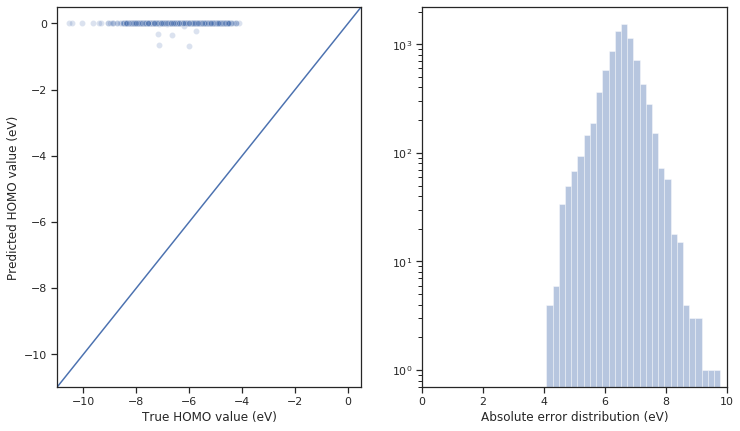

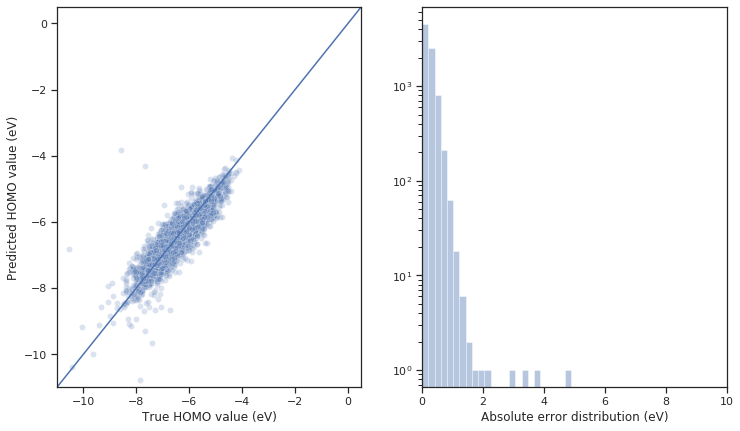

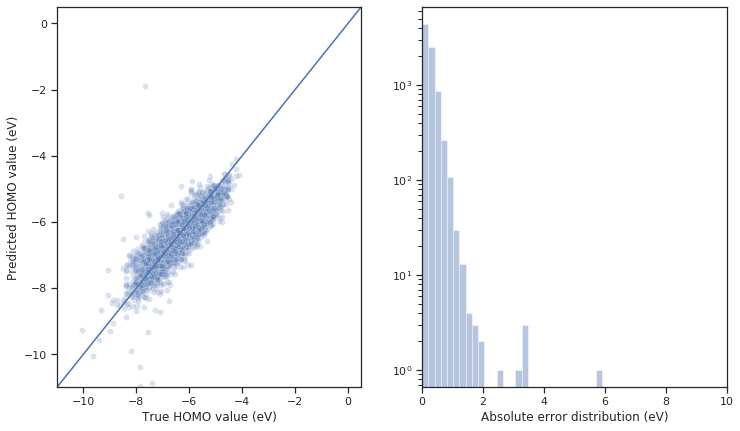

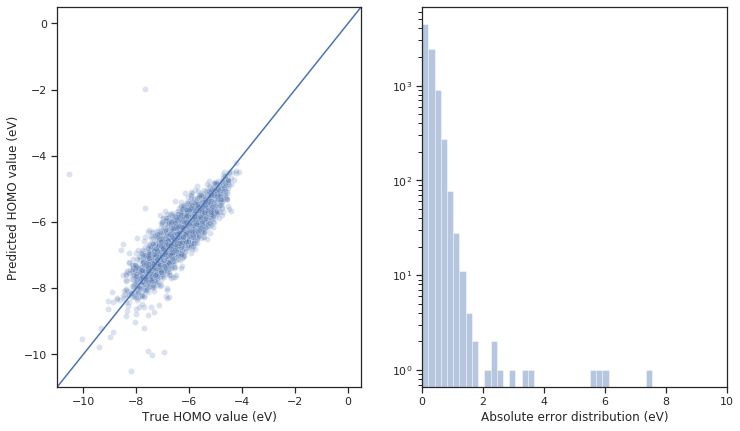

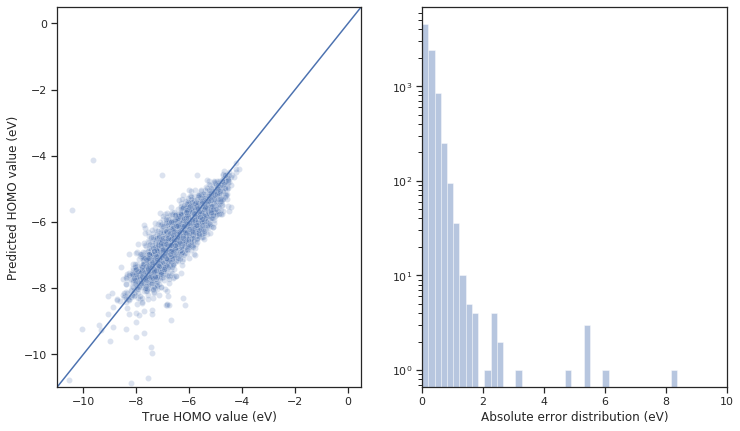

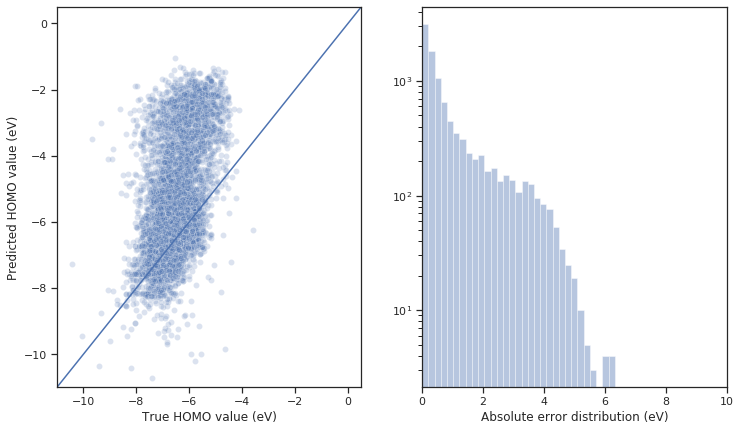

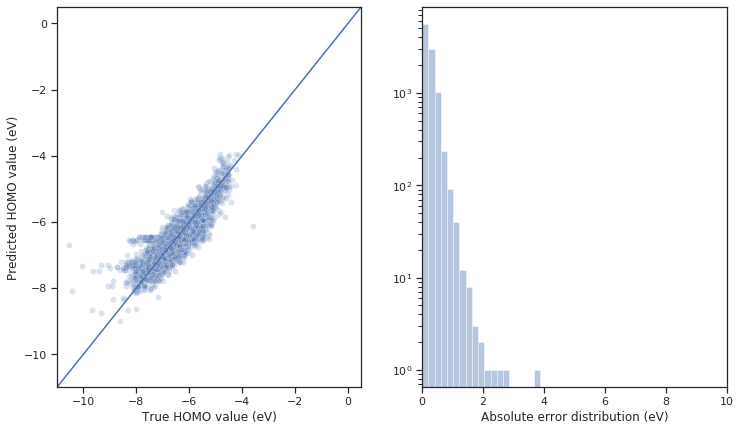

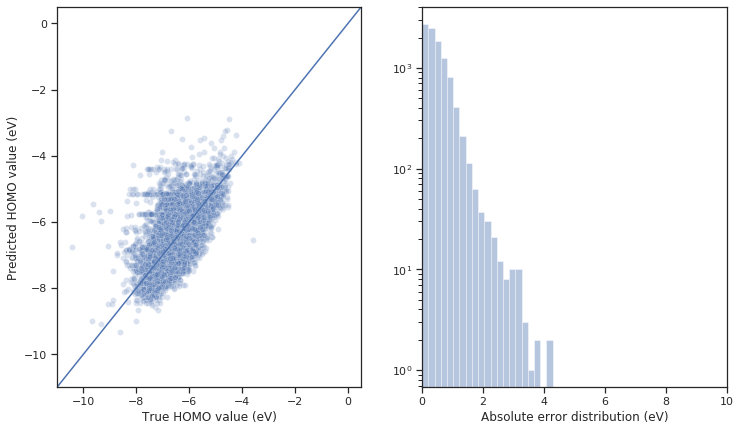

In [11]:
procedure(models, descriptors, objective, output_results_path, preprocessing=None)

In [ ]:
from sklearn.preprocessing import StandardScaler

procedure(models, descriptors, objective, output_results_path, preprocessing=StandardScaler())

In [ ]:
from sklearn.preprocessing import Normalizer

procedure(models, descriptors, objective, output_results_path, preprocessing=Normalizer())

### Reloading data from filesystem

In [ ]:
import pandas as pd
import numpy as np

def load_saved_data(output_path=output_results_path, preprocessing=None, columns_ids=range(1, 7)):
    
    # Computing the name of the experiment based on the preprocessing
    exp_name = "preprocessing_" + str(preprocessing.__class__.__name__) if preprocessing is not None else "no_preprocessing"
    output_folder = join(output_path, exp_name)
    
    CV_score_best_params_dict = pd.read_csv(join(output_folder, "CV_score_best_params.csv"), sep=';', usecols=columns_ids, index_col=0)  
    validation_score_best_params_dict = pd.read_csv(join(output_folder, "validation_score_best_params.csv"), sep=';', usecols=columns_ids, index_col=0)
    mean_train_time_dict = pd.read_csv(join(output_folder, "mean_train_time.csv"), sep=';', usecols=columns_ids, index_col=0)
    best_alpha_dict = pd.read_csv(join(output_folder, "best_alpha.csv"), sep=';', usecols=columns_ids, index_col=0)
    cv_results_dict = pd.read_csv(join(output_folder, "cv_results.csv"), sep=';', usecols=columns_ids, index_col=0)
    
    data_dict = {
        "CV_score_best_params_dict": CV_score_best_params_dict,
        "validation_score_best_params_dict": validation_score_best_params_dict,
        "mean_train_time_dict": mean_train_time_dict,
        "best_alpha_dict": best_alpha_dict,
        "cv_results_dict": cv_results_dict
    }
    
    return data_dict

In [ ]:
from sklearn.preprocessing import StandardScaler, Normalizer

no_preprocessing_data = load_saved_data(preprocessing=None)
standard_scaling_data = load_saved_data(preprocessing=StandardScaler())
normalization_data = load_saved_data(preprocessing=Normalizer())

In [ ]:
from IPython.display import display, HTML

def display_effect(data1, data2, exp_name1, exp_name2, metric):
    
    display(HTML('<h3>' + "Effect of using " + exp_name2 + " rather than " + exp_name1 +
                 " for " + metric + ' (%)</h3>'))
    with pd.option_context('display.float_format', '{:0.2f}'.format):
        display((data2.sub(data1)).div(data1).mul(100))

def compare_preprocessing_method(data1, data2, preprocessing1, preprocessing2):
    
    exp_name1 = "preprocessing_" + str(preprocessing1.__class__.__name__) if preprocessing1 is not None else "no_preprocessing"
    exp_name2 = "preprocessing_" + str(preprocessing2.__class__.__name__) if preprocessing2 is not None else "no_preprocessing"
    
    CV_score1 = data1["CV_score_best_params_dict"]
    CV_score2 = data2["CV_score_best_params_dict"]
    validation1 = data1["validation_score_best_params_dict"]
    validation2 = data2["validation_score_best_params_dict"]
    mean_time1 = data1["mean_train_time_dict"]
    mean_time2 = data2["mean_train_time_dict"]
        
    display_effect(CV_score1, CV_score2, exp_name1, exp_name2, "mean CV score")
    display_effect(validation1, validation2, exp_name1, exp_name2, "validation score")
    display_effect(mean_time1, mean_time2, exp_name1, exp_name2, "mean train time")


# Study of preprocessing

## No preprocessing vs standard scaling

Conclusion : Standard scaling decreases almost all metrics

In [ ]:
compare_preprocessing_method(no_preprocessing_data, standard_scaling_data, None, StandardScaler())

## No preprocessing vs normalization

Conclusion : Normalization has an very important positive effect on scores obtained using RBF kernel. It has a slightly negative effect on the training time for most experiments and on the scores for SOAP kernel

In [ ]:
compare_preprocessing_method(no_preprocessing_data, normalization_data, None, Normalizer())

# Study of GPR hyperparameters optimization (with normalization)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern, RationalQuadratic, DotProduct


kernels = [("RBF( 1.0)", RBF(1.0)),
           ("DotProduct( sigma_0=1)", DotProduct(sigma_0=1))]

models = []
for kernel in kernels:
    models.append((kernel[0], GaussianProcessRegressor(kernel=kernel[1], optimizer="fmin_l_bfgs_b")))


In [ ]:
from bbo.descriptor import SOAPDesc, ShinglesVectDesc, MBTRDesc, CoulombMatrixDesc

descriptors = [
    ("SOAP", SOAPDesc(cache_location=None, n_jobs=12, average="inner", rcut=4, nmax=6, 
                      lmax=8, species=["C", "H", "O", "N", "F"])),
    ("Shingles bool", ShinglesVectDesc(cache_location=None)),
    ("Shingles count", ShinglesVectDesc(cache_location=None, count=True)),
    ("MBTR", MBTRDesc(cache_location=None, n_jobs=12, cosine_angles_n=45, atomic_numbers_n=10, 
                      inverse_distances_n=45, species=["C", "H", "O", "N", "F"])),
    ("CM", CoulombMatrixDesc(n_atoms_max=29, cache_location=None, n_jobs=12)),
    
]

In [ ]:
from sklearn.preprocessing import Normalizer

procedure(models, descriptors, objective, hyperparameters_optim_output_results_path, preprocessing=Normalizer())

In [ ]:
no_optim_normalization_data = load_saved_data(preprocessing=Normalizer())
optim_normalization_data = load_saved_data(output_path=hyperparameters_optim_output_results_path,
                                           preprocessing=Normalizer())

In [ ]:
from IPython.display import display, HTML

def compare_methods(data1, data2, exp_name1, exp_name2):
    
    CV_score1 = data1["CV_score_best_params_dict"]
    CV_score2 = data2["CV_score_best_params_dict"]
    validation1 = data1["validation_score_best_params_dict"]
    validation2 = data2["validation_score_best_params_dict"]
    mean_time1 = data1["mean_train_time_dict"]
    mean_time2 = data2["mean_train_time_dict"]
                
    display_effect(CV_score1, CV_score2, exp_name1, exp_name2, "mean CV score")
    display_effect(validation1, validation2, exp_name1, exp_name2, "validation score")
    display_effect(mean_time1, mean_time2, exp_name1, exp_name2, "mean train time")

In [ ]:
compare_methods(no_optim_normalization_data, optim_normalization_data, "no optimization", "optimization")

# Study of DFT geometrical data 

In [ ]:
import json

with open(json_cache_location, "r") as f:
    _cache_dict = json.load(f)

def DFT_cache_geom(smiles, **kwargs):
    return "".join(_cache_dict[smiles]["xyz"]), True

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern, RationalQuadratic, DotProduct


kernels = [("RBF( 1.0)", RBF(1.0)),
           ("DotProduct( sigma_0=1)", DotProduct(sigma_0=1)),
           ("SOAP( xi=1)", SOAPKernelVectorized(xi=1)),
           ("SOAP( xi=2)", SOAPKernelVectorized(xi=2)),
           ("SOAP( xi=3)", SOAPKernelVectorized(xi=3))]

models = []
for kernel in kernels:
    models.append((kernel[0], GaussianProcessRegressor(kernel=kernel[1], optimizer=None)))

In [ ]:
descriptors_geom_DFT = [
    ("SOAP", SOAPDesc(cache_location=None, n_jobs=1, average="inner", rcut=4, nmax=6, 
                      lmax=8, species=["C", "H", "O", "N", "F"], geometry_function=DFT_cache_geom)),
    ("MBTR", MBTRDesc(cache_location=None, n_jobs=1, cosine_angles_n=45, atomic_numbers_n=10, 
                      inverse_distances_n=45, species=["C", "H", "O", "N", "F"], geometry_function=DFT_cache_geom)),
    ("CM", CoulombMatrixDesc(n_atoms_max=29, cache_location=None, n_jobs=1, geometry_function=DFT_cache_geom)),
]

In [ ]:
procedure(models, descriptors_geom_DFT, objective, output_results_path=DFT_output_results_path,
          preprocessing=None)

In [ ]:
procedure(models, descriptors_geom_DFT, objective, output_results_path=DFT_output_results_path,
          preprocessing=Normalizer())

In [ ]:
no_preprocessing_data = load_saved_data(preprocessing=None, columns_ids=[1, 2, 5, 6])
normalization_data = load_saved_data(preprocessing=Normalizer(), columns_ids=[1, 2, 5, 6])
no_preprocessing_data_DFT = load_saved_data(output_path=DFT_output_results_path, preprocessing=None,
                                            columns_ids=range(1, 5))
normalization_data_DFT = load_saved_data(output_path=DFT_output_results_path, preprocessing=Normalizer(),
                                         columns_ids=range(1, 5))

## No preprocessing

In [ ]:
compare_methods(no_preprocessing_data, no_preprocessing_data_DFT, "geom_MM", "geom_QM")

## Normalization

In [ ]:
compare_methods(normalization_data, normalization_data_DFT, "geom_MM", "geom_QM")

# Study of bigger datasets

### New experiment on more data (20k train samples) on the best model (DFT geometry+MBTR+RBF Kernel+Normalization)

In [ ]:
N_MOL_TRAIN_TEST = 20000
N_MOL_VALIDATION = 10000
CV = 2
ALPHAS = [1e0, 1e-1, 1e-3]
N_JOBS = 2


In [ ]:
from sklearn.preprocessing import Normalizer

descriptors = [
    ("MBTR", MBTRDesc(cache_location=None, n_jobs=1, cosine_angles_n=45, atomic_numbers_n=10, 
                      inverse_distances_n=45, species=["C", "H", "O", "N", "F"],
                      geometry_function=DFT_cache_geom))
]



kernels = [("RBF( 1.0)", RBF(1.0))]

models = []
for kernel in kernels:
    models.append((kernel[0], GaussianProcessRegressor(kernel=kernel[1], optimizer=None)))


In [ ]:
procedure(models, descriptors, objective, output_results_path=test_20k_output_results_path,
          preprocessing=Normalizer())

### New experiment on more data (20k training samples) on the fast models (MBTR/SOAP/Shingles count+DOTProduct/SOAP^3 Kernel+Normalization) still using DFT geometry

In [ ]:
N_MOL_TRAIN_TEST = 20000
N_MOL_VALIDATION = 10000
CV = 2
ALPHAS = [1e0, 1e-1, 1e-3, 1e-5, 1e-7]
N_JOBS = 2

In [ ]:
descriptors = [
    ("MBTR", MBTRDesc(cache_location=None, n_jobs=1, cosine_angles_n=45, atomic_numbers_n=10, 
                      inverse_distances_n=45, species=["C", "H", "O", "N", "F"], 
                      geometry_function=DFT_cache_geom)),
    ("SOAP", SOAPDesc(cache_location=None, n_jobs=1, average="inner", rcut=4, nmax=6, 
                      lmax=8, species=["C", "H", "O", "N", "F"], geometry_function=DFT_cache_geom)),
    ("Shingles count", ShinglesVectDesc(cache_location=None, count=True))
]

kernels = [("DotProduct( sigma_0=1)", DotProduct(sigma_0=1)),
           ("SOAP( xi=3)", SOAPKernelVectorized(xi=3))]

models = []
for kernel in kernels:
    models.append((kernel[0], GaussianProcessRegressor(kernel=kernel[1], optimizer=None)))



In [ ]:
from sklearn.preprocessing import Normalizer

procedure(models, descriptors, objective, output_results_path=test_20k_fast_output_results_path,
          preprocessing=Normalizer())